[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/langchain-ai/langchain-academy/blob/main/module-1/chain.ipynb) [![Open in LangChain Academy](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/66e9eba12c7b7688aa3dbb5e_LCA-badge-green.svg)](https://academy.langchain.com/courses/take/intro-to-langgraph/lessons/58238466-lesson-4-chain)


# 链（Chain）

## 回顾

我们之前构建了一个包含节点、普通边和条件边的简单图。

## 目标

现在，让我们构建一个简单的链，结合 4 个[概念](https://python.langchain.com/v0.2/docs/concepts/)：

* 使用[聊天消息](https://python.langchain.com/v0.2/docs/concepts/#messages)作为图状态
* 在图节点中使用[聊天模型](https://python.langchain.com/v0.2/docs/concepts/#chat-models)
* 为聊天模型[绑定工具](https://python.langchain.com/v0.2/docs/concepts/#tools)
* 在图节点中[执行工具调用](https://python.langchain.com/v0.2/docs/concepts/#functiontool-calling)

![Screenshot 2024-08-21 at 9.24.03 AM.png](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/66dbab08dd607b08df5e1101_chain1.png)


In [1]:
%%capture --no-stderr
%pip install --quiet -U langchain_openai langchain_core langgraph

## 消息（Messages）

聊天模型可以使用[`messages`](https://python.langchain.com/v0.2/docs/concepts/#messages)，用于表达对话中的不同角色。

LangChain 支持多种消息类型，包括 `HumanMessage`、`AIMessage`、`SystemMessage` 和 `ToolMessage`。

它们分别表示：来自用户的消息、来自聊天模型的消息、用于指导模型行为的系统消息，以及来自工具调用的消息。

我们先创建一组消息列表。

每条消息可以包含以下内容：

* `content` —— 消息内容
* `name` —— 可选，消息作者
* `response_metadata` —— 可选，元数据字典（例如，常由模型提供商为 `AIMessage` 填充）


In [ ]:
from pprint import pprint
from langchain_core.messages import AIMessage, HumanMessage

messages = [
    AIMessage(content=f"So you said you were researching ocean mammals?", name="Model")
]
messages.append(HumanMessage(content=f"Yes, that's right.", name="Lance"))
messages.append(
    AIMessage(content=f"Great, what would you like to learn about.", name="Model")
)
messages.append(
    HumanMessage(
        content=f"I want to learn about the best place to see Orcas in the US.",
        name="Lance",
    )
)

for m in messages:
    m.pretty_print()

================================== Ai Message ==================================
Name: Model

So you said you were researching ocean mammals?
================================ Human Message =================================
Name: Lance

Yes, that's right.
================================== Ai Message ==================================
Name: Model

Great, what would you like to learn about.
================================ Human Message =================================
Name: Lance

I want to learn about the best place to see Orcas in the US.


## 聊天模型（Chat Models）

[聊天模型](https://python.langchain.com/v0.2/docs/concepts/#chat-models) 可以接收一系列消息作为输入，并支持上述消息类型。

可选的[模型很多](https://python.langchain.com/v0.2/docs/concepts/#chat-models)！这里我们使用 OpenAI。

先检查你的 `OPENAI_API_KEY` 是否已设置；如果没有，代码会提示你输入。


In [ ]:
import os, getpass


def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")


# _set_env("OPENAI_API_KEY")
_set_env("DASHSCOPE_API_KEY")

我们可以加载一个聊天模型，并用我们的消息列表调用它。

可以看到结果是一个带有特定 `response_metadata` 的 `AIMessage`。


In [4]:
# from langchain_openai import ChatOpenAI
# llm = ChatOpenAI(model="gpt-4o")

from langchain_community.chat_models import ChatTongyi

llm = ChatTongyi(model="qwen-plus")

result = llm.invoke(messages)
type(result)

langchain_core.messages.ai.AIMessage

In [5]:
result

AIMessage(content='One of the best places in the U.S. to see orcas (also known as killer whales) in the wild is **Puget Sound in Washington State**, particularly around the **San Juan Islands**.\n\nThe waters near **Friday Harbor, Lime Kiln Point State Park**, and **Orcas Island** are especially famous for orca sightings. This area is home to the **southern resident orca population**, which consists of three pods—J, K, and L—that frequently travel through these inland waterways in search of salmon, especially Chinook salmon, their primary food source.\n\n**Best time to visit:**  \nThe peak season for orca viewing is typically from **spring through fall (May to October)**, when salmon runs attract the whales closer to shore.\n\nIn addition to boat tours, you can sometimes spot orcas from land at **Lime Kiln Point**, known as one of the best whale-watching sites in the world for viewing orcas from the shoreline.\n\nOther notable places in the U.S. where orcas are occasionally seen includ

In [6]:
result.response_metadata

{'model_name': 'qwen-plus',
 'finish_reason': 'stop',
 'request_id': '77642f69-8c48-4f4c-9e24-44bd4ecd6d4e',
 'token_usage': {'input_tokens': 69,
  'output_tokens': 285,
  'total_tokens': 354,
  'prompt_tokens_details': {'cached_tokens': 0}}}

## 工具（Tools）

当你希望模型与外部系统交互时，工具就很有用。

外部系统（例如 API）通常需要特定的输入模式或载荷，而非自然语言。

当我们将某个 API 绑定为工具时，就让模型了解了其所需的输入模式。

模型会基于用户的自然语言输入来决定是否调用某个工具。

同时，工具的输出会遵循该工具的模式。

[许多 LLM 提供商支持工具调用](https://python.langchain.com/v0.1/docs/integrations/chat/)，而 LangChain 的[工具调用接口](https://blog.langchain.dev/improving-core-tool-interfaces-and-docs-in-langchain/)也很简单。

你可以把任意 Python `function` 传给 `ChatModel.bind_tools(function)`。


下面展示一个简单的工具调用示例！

`multiply` 函数就是我们的工具。


In [7]:
def multiply(a: int, b: int) -> int:
    """Multiply a and b.

    Args:
        a: first int
        b: second int
    """
    return a * b


llm_with_tools = llm.bind_tools([multiply])

如果我们传入一个输入，比如 `"What is 2 multiplied by 3"`，就会看到返回了一个工具调用。

工具调用包含与函数输入模式相匹配的具体参数，以及要调用的函数名。

```
{'arguments': '{"a":2,"b":3}', 'name': 'multiply'}
```


In [8]:
tool_call = llm_with_tools.invoke(
    [HumanMessage(content=f"What is 2 multiplied by 3", name="Lance")]
)

In [9]:
tool_call.tool_calls

[{'name': 'multiply',
  'args': {'a': 2, 'b': 3},
  'id': 'call_cb7182aca05645a5949921',
  'type': 'tool_call'}]

## 将消息作为状态使用

在这些基础之上，我们可以在图状态中使用[`messages`](https://python.langchain.com/v0.2/docs/concepts/#messages)。

我们把状态 `MessagesState` 定义为一个只包含单个键 `messages` 的 `TypedDict`。

`messages` 就是我们上面定义的消息列表（例如 `HumanMessage` 等）。


In [10]:
from typing_extensions import TypedDict
from langchain_core.messages import AnyMessage


class MessagesState(TypedDict):
    messages: list[AnyMessage]

## 归约器（Reducers）

我们遇到了一个小问题！

如前所述，每个节点都会为状态键 `messages` 返回一个新值。

但这个新值会[覆盖](https://langchain-ai.github.io/langgraph/concepts/low_level/#reducers)之前的 `messages` 值。

而在图的执行过程中，我们希望把新消息**追加**到 `messages` 中。

我们可以使用[归约器函数](https://langchain-ai.github.io/langgraph/concepts/low_level/#reducers)来解决这一点。

归约器允许我们指定状态更新的方式。

如果没有指定归约器函数，就会像之前看到的那样，默认认为对该键的更新应当是覆盖。

但如果要追加消息，我们可以使用预置的 `add_messages` 归约器。

这样就可以确保任何消息都会被追加到现有的消息列表中。

我们只需要在 `messages` 键的元数据中标注 `add_messages` 这个归约器函数即可。


In [11]:
from typing import Annotated
from langgraph.graph.message import add_messages


class MessagesState(TypedDict):
    messages: Annotated[list[AnyMessage], add_messages]

由于在图状态中维护消息列表非常常见，LangGraph 提供了一个预构建的 [`MessagesState`](https://langchain-ai.github.io/langgraph/concepts/low_level/#messagesstate)！

`MessagesState` 的定义：

* 预置了一个 `messages` 键
* 它是 `AnyMessage` 对象的列表
* 使用了 `add_messages` 归约器

通常我们会使用 `MessagesState`，因为它比自己定义 `TypedDict` 更简洁。


In [12]:
from langgraph.graph import MessagesState


class MessagesState(MessagesState):
    # Add any keys needed beyond messages, which is pre-built
    pass

更进一步，我们可以单独看看 `add_messages` 归约器是如何工作的。


In [13]:
# Initial state
initial_messages = [
    AIMessage(content="Hello! How can I assist you?", name="Model"),
    HumanMessage(
        content="I'm looking for information on marine biology.", name="Lance"
    ),
]

# New message to add
new_message = AIMessage(
    content="Sure, I can help with that. What specifically are you interested in?",
    name="Model",
)

# Test
add_messages(initial_messages, new_message)

[AIMessage(content='Hello! How can I assist you?', additional_kwargs={}, response_metadata={}, name='Model', id='cd9f963b-6fca-49eb-b355-222e23d63dfa'),
 HumanMessage(content="I'm looking for information on marine biology.", additional_kwargs={}, response_metadata={}, name='Lance', id='8b46575f-fb8c-4cb0-b23f-1877ac0285f4'),
 AIMessage(content='Sure, I can help with that. What specifically are you interested in?', additional_kwargs={}, response_metadata={}, name='Model', id='d66c88f1-b07d-42ce-9ce7-265b46357f65')]

## 我们的图

现在，让我们在图中使用 `MessagesState`。


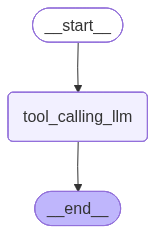

In [16]:
from IPython.display import Image, display
from langgraph.graph import StateGraph, START, END


# Node
def tool_calling_llm(state: MessagesState):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}


# Build graph
builder = StateGraph(MessagesState)
builder.add_node("tool_calling_llm", tool_calling_llm)
builder.add_edge(START, "tool_calling_llm")
builder.add_edge("tool_calling_llm", END)
graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png(max_retries=5, retry_delay=2.0)))

如果传入 `Hello!`，LLM 会在不调用任何工具的情况下直接回复。


In [17]:
messages = graph.invoke({"messages": HumanMessage(content="Hello!")})
for m in messages["messages"]:
    m.pretty_print()

================================ Human Message =================================

Hello!
================================== Ai Message ==================================

Hello! How can I assist you today?


当输入或任务需要某个工具提供的功能时，LLM 会选择使用该工具。


In [18]:
messages = graph.invoke({"messages": HumanMessage(content="Multiply 2 and 3")})
for m in messages["messages"]:
    m.pretty_print()

================================ Human Message =================================

Multiply 2 and 3
================================== Ai Message ==================================
Tool Calls:
  multiply (call_e2ef983e738848ed869d63)
 Call ID: call_e2ef983e738848ed869d63
  Args:
    a: 2
    b: 3
